# RFM Analysis

Assessing and segmenting customers based on buying behavior including:

Recency: date of last purchase

Frequency: how often purchases are made

Monetary value: amount spent on purchases

In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
pio.templates.default = "plotly_white"
#have Kaleido installed to view static visuals

data = pd.read_csv('rfm_data.csv')
data.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris


In [7]:
from datetime import datetime
import datetime as dt

# Convert 'PurchaseDate' to datetime
data['PurchaseDate'] = pd.to_datetime(data['PurchaseDate'])

#add a column with today's date to use for subtraction to find recency value
data['today'] = datetime.now().date()
#convert the 'today' column to datetime
data['today'] = pd.to_datetime(data['today'])
#^ The above steps are taken to avoid errors that often arise processing datetime objects, subtracting two columns is simpler

#calculate recency
data['Recency'] = data['today'] - data['PurchaseDate']

In [8]:
# Calculate Frequency
frequency_data = data.groupby('CustomerID')['OrderID'].count().reset_index()
frequency_data.rename(columns={'OrderID': 'Frequency'}, inplace=True)
data = data.merge(frequency_data, on='CustomerID', how='left')

In [9]:
# Calculate Monetary Value
monetary_data = data.groupby('CustomerID')['TransactionAmount'].sum().reset_index()
monetary_data.rename(columns={'TransactionAmount': 'MonetaryValue'}, inplace=True)
data = data.merge(monetary_data, on='CustomerID', how='left')

In [10]:
data.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,today,Recency,Frequency,MonetaryValue
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,2023-09-11,153 days,1,943.31
1,2188,2023-04-11,463.70,Product A,176819,London,2023-09-11,153 days,1,463.70
2,4608,2023-04-11,80.28,Product A,340062,New York,2023-09-11,153 days,1,80.28
3,2559,2023-04-11,221.29,Product A,239145,London,2023-09-11,153 days,1,221.29
4,9482,2023-04-11,739.56,Product A,194545,Paris,2023-09-11,153 days,1,739.56


In [11]:
#Calculate scores to associate with the recency, frequency and monetary values

# Define scoring criteria for each RFM value
recency_scores = [5, 4, 3, 2, 1]  # Higher score for lower recency (more recent)
frequency_scores = [1, 2, 3, 4, 5]  # Higher score for higher frequency
monetary_scores = [1, 2, 3, 4, 5]  # Higher score for higher monetary value

# Calculate RFM scores
data['RecencyScore'] = pd.cut(data['Recency'], bins=5, labels=recency_scores)
data['FrequencyScore'] = pd.cut(data['Frequency'], bins=5, labels=frequency_scores)
data['MonetaryScore'] = pd.cut(data['MonetaryValue'], bins=5, labels=monetary_scores)

In [19]:
# Convert RFM scores to numeric type
data['RecencyScore'] = data['RecencyScore'].astype(int)
data['FrequencyScore'] = data['FrequencyScore'].astype(int)
data['MonetaryScore'] = data['MonetaryScore'].astype(int)

In [20]:
# Calculate RFM score by combining the individual scores
data['RFM_Score'] = data['RecencyScore'] + data['FrequencyScore'] + data['MonetaryScore']

# Create RFM segments based on the RFM score
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
data['Value Segment'] = pd.qcut(data['RFM_Score'], q=3, labels=segment_labels)

In [21]:
#results:
data.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location,today,Recency,Frequency,MonetaryValue,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,Value Segment
0,8814,2023-04-11,943.31,Product C,890075,Tokyo,2023-09-11,153 days,1,943.31,1,1,2,4,Low-Value
1,2188,2023-04-11,463.70,Product A,176819,London,2023-09-11,153 days,1,463.70,1,1,1,3,Low-Value
2,4608,2023-04-11,80.28,Product A,340062,New York,2023-09-11,153 days,1,80.28,1,1,1,3,Low-Value
3,2559,2023-04-11,221.29,Product A,239145,London,2023-09-11,153 days,1,221.29,1,1,1,3,Low-Value
4,9482,2023-04-11,739.56,Product A,194545,Paris,2023-09-11,153 days,1,739.56,1,1,2,4,Low-Value


/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1958: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(required_grouper, sort=False)  # skip one_group groupers


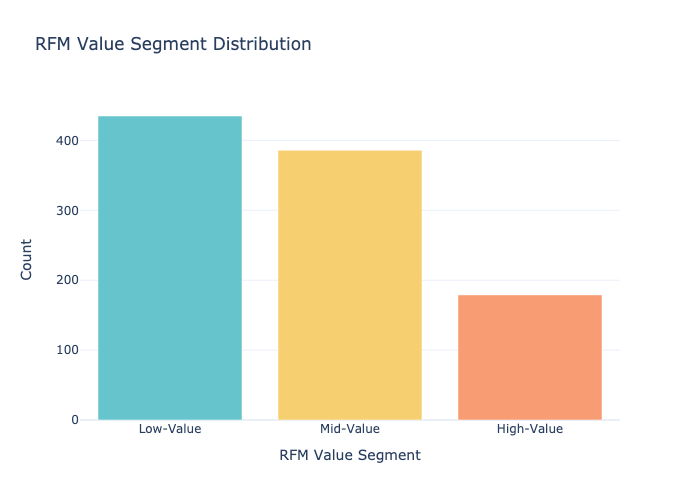

In [22]:
# RFM Segment Distribution
segment_counts = data['Value Segment'].value_counts().reset_index()
segment_counts.columns = ['Value Segment', 'Count']

pastel_colors = px.colors.qualitative.Pastel

# Create the bar chart
fig_segment_dist = px.bar(segment_counts, x='Value Segment', y='Count', 
                          color='Value Segment', color_discrete_sequence=pastel_colors,
                          title='RFM Value Segment Distribution')

# Update the layout
fig_segment_dist.update_layout(xaxis_title='RFM Value Segment',
                              yaxis_title='Count',
                              showlegend=False)

# Show the figure
fig_segment_dist.show('png') #'png' added to produce static image, better for notebook previews

In [24]:
data['RFM Customer Segments'] = ''

# Assign RFM segments based on the RFM score
data.loc[data['RFM_Score'] >= 9, 'RFM Customer Segments'] = 'Champions'
data.loc[(data['RFM_Score'] >= 6) & (data['RFM_Score'] < 9), 'RFM Customer Segments'] = 'Potential Loyalists'
data.loc[(data['RFM_Score'] >= 5) & (data['RFM_Score'] < 6), 'RFM Customer Segments'] = 'At Risk Customers'
data.loc[(data['RFM_Score'] >= 4) & (data['RFM_Score'] < 5), 'RFM Customer Segments'] = "Can't Lose"
data.loc[(data['RFM_Score'] >= 3) & (data['RFM_Score'] < 4), 'RFM Customer Segments'] = "Lost"

# Print the updated data with RFM segments
data[['CustomerID', 'RFM Customer Segments']].head()

,CustomerID,RFM Customer Segments
0,8814,Can't Lose
1,2188,Lost
2,4608,Lost
3,2559,Lost
4,9482,Can't Lose


/var/folders/7b/2chhqpbn0hng196cw18_j44m0000gn/T/ipykernel_86596/2412186152.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1619: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/anaconda3/lib/python3.9/site-packages/plotly/express/_core.py:1619: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



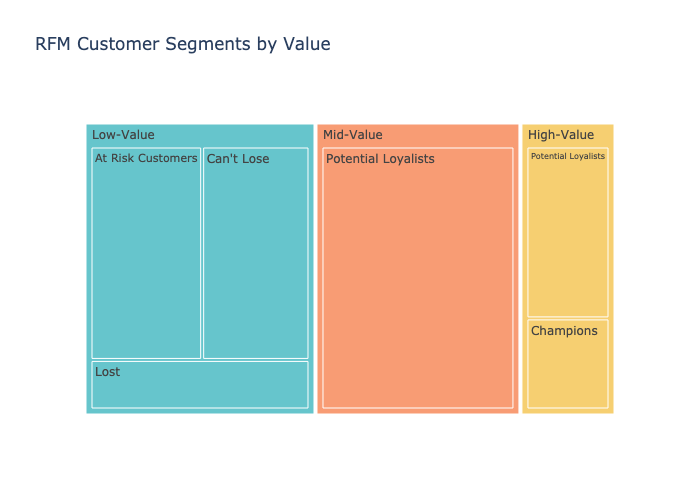

In [25]:
#Analyze the distribution of cusomers across different RFM segments within each value segment
segment_product_counts = data.groupby(['Value Segment', 'RFM Customer Segments']).size().reset_index(name='Count')

segment_product_counts = segment_product_counts.sort_values('Count', ascending=False)

fig_treemap_segment_product = px.treemap(segment_product_counts, 
                                         path=['Value Segment', 'RFM Customer Segments'], 
                                         values='Count',
                                         color='Value Segment', color_discrete_sequence=px.colors.qualitative.Pastel,
                                         title='RFM Customer Segments by Value')
fig_treemap_segment_product.show('png')

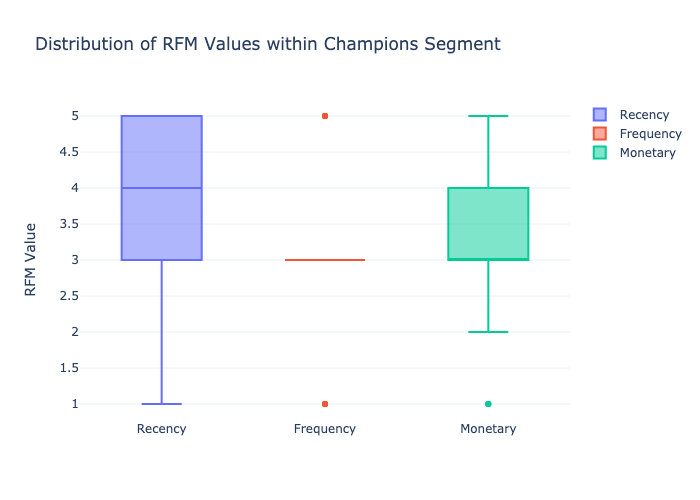

In [26]:
#Analyze the distribution of RFM values within the Champions segment

# Filter the data to include only the customers in the Champions segment
champions_segment = data[data['RFM Customer Segments'] == 'Champions']

fig = go.Figure()
fig.add_trace(go.Box(y=champions_segment['RecencyScore'], name='Recency'))
fig.add_trace(go.Box(y=champions_segment['FrequencyScore'], name='Frequency'))
fig.add_trace(go.Box(y=champions_segment['MonetaryScore'], name='Monetary'))

fig.update_layout(title='Distribution of RFM Values within Champions Segment',
                  yaxis_title='RFM Value',
                  showlegend=True)

fig.show('png')

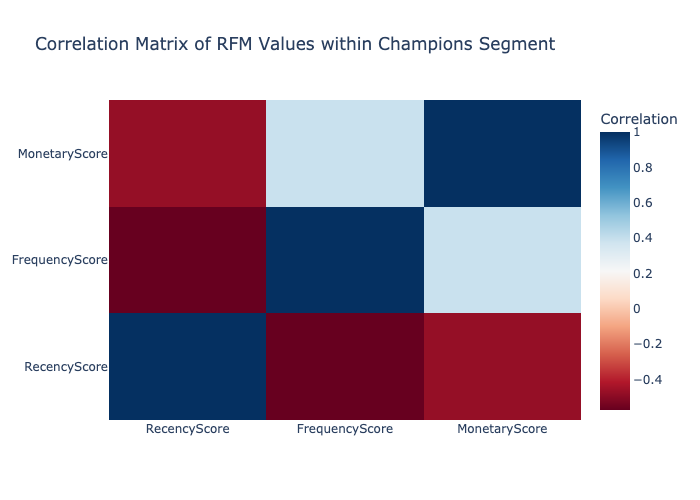

In [27]:
#analyze the correlation of the recency, frequency, and monetary scores within the champions segment

correlation_matrix = champions_segment[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].corr()

# Visualize the correlation matrix using a heatmap
fig_heatmap = go.Figure(data=go.Heatmap(
                   z=correlation_matrix.values,
                   x=correlation_matrix.columns,
                   y=correlation_matrix.columns,
                   colorscale='RdBu',
                   colorbar=dict(title='Correlation')))

fig_heatmap.update_layout(title='Correlation Matrix of RFM Values within Champions Segment')

fig_heatmap.show('png')

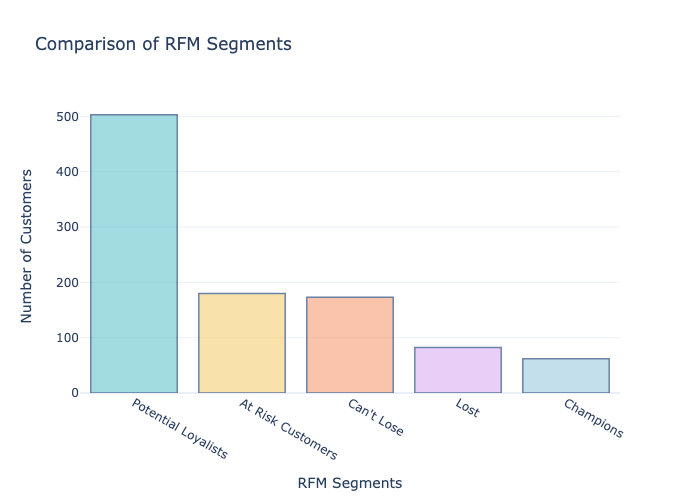

In [28]:
#Look at the number of customers in each segment
import plotly.colors

pastel_colors = plotly.colors.qualitative.Pastel

segment_counts = data['RFM Customer Segments'].value_counts()

# Create a bar chart to compare segment counts
fig = go.Figure(data=[go.Bar(x=segment_counts.index, y=segment_counts.values,
                            marker=dict(color=pastel_colors))])

# Set the color of the Champions segment as a different color
champions_color = 'rgb(158, 202, 225)'
fig.update_traces(marker_color=[champions_color if segment == 'Champions' else pastel_colors[i]
                                for i, segment in enumerate(segment_counts.index)],
                  marker_line_color='rgb(8, 48, 107)',
                  marker_line_width=1.5, opacity=0.6)

# Update the layout
fig.update_layout(title='Comparison of RFM Segments',
                  xaxis_title='RFM Segments',
                  yaxis_title='Number of Customers',
                  showlegend=False)

fig.show('png')

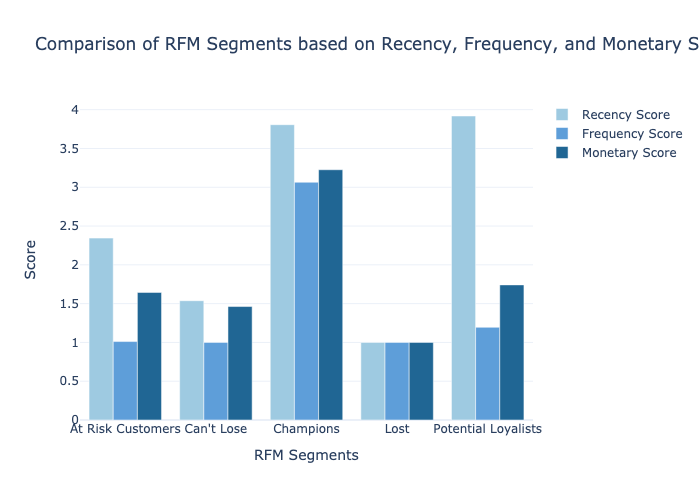

In [31]:
# Calculate the average Recency, Frequency, and Monetary scores for each segment
segment_scores = data.groupby('RFM Customer Segments')[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].mean().reset_index()

# Create a grouped bar chart to compare segment scores
fig = go.Figure()

# Add bars for Recency score
fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segments'],
    y=segment_scores['RecencyScore'],
    name='Recency Score',
    marker_color='rgb(158,202,225)'
))

# Add bars for Frequency score
fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segments'],
    y=segment_scores['FrequencyScore'],
    name='Frequency Score',
    marker_color='rgb(94,158,217)'
))

# Add bars for Monetary score
fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segments'],
    y=segment_scores['MonetaryScore'],
    name='Monetary Score',
    marker_color='rgb(32,102,148)'
))

# Update the layout
fig.update_layout(
    title='Comparison of RFM Segments based on Recency, Frequency, and Monetary Scores',
    xaxis_title='RFM Segments',
    yaxis_title='Score',
    barmode='group',
    showlegend=True
)

fig.show('png')